In [1]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot
import numpy
from scipy.linalg import solve_triangular
import sys
sys.path.append('../src/')
import factors
import measures
import densities

### General Form of a Gaussian

$p(x) = \exp(-\frac{1}{2}x^\top\Lambda x + x^\top\nu - \ln Z)$

with $\ln Z = \frac{1}{2}\nu^\top\Lambda^{-1}\nu + \frac{D}{2}\ln 2\pi + \frac{1}{2}\ln\det(\Lambda^{-1})$.

### Relation to covariance and mean

$\Sigma = \Lambda^{-1}$

$\mu = \Sigma\nu$

### Form of unnormalised Gaussians

$u(x) = \exp(-\frac{1}{2}x^\top\Lambda x + x^\top\nu + \ln \beta)$

And the intergal is

$\int u(x) d x = \beta Z$

### List of intergals

### Test for 1 D

In [2]:
R, D, R1 = 2, 1, 1
rand_nums = numpy.random.randn(D,D)
Sigma_phi = .5 * numpy.dot(rand_nums, rand_nums.T) + D * numpy.eye(D)
Sigma_phi = numpy.tile(Sigma_phi, (R, 1, 1))
mu_phi = numpy.random.randn(R, D)
phi = densities.GaussianDensity(Sigma=Sigma_phi, mu=mu_phi)

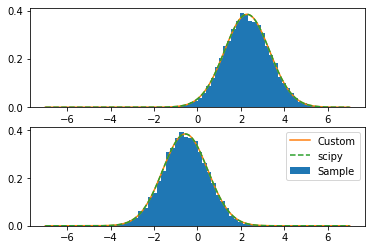

In [3]:
from scipy.stats import norm

xrange = numpy.linspace(-7,7,1000)
for ir in range(R):
    pyplot.subplot(R, 1, ir+1)
    scipy_gauss = norm.pdf(xrange, loc=mu_phi[ir], scale=numpy.sqrt(Sigma_phi[ir,0,0]))
    pyplot.hist(phi.sample(10000)[:,ir], bins=40, density=True, label='Sample')
    pyplot.plot(xrange, phi.evaluate(numpy.array([xrange]).T)[ir], label='Custom')
    pyplot.plot(xrange, scipy_gauss, '--', label='scipy')
pyplot.legend()
pyplot.show()

### Test for integral linear integrals

$\int x du(x)$

In [4]:
R, D, R1 = 10, 3, 1
rand_nums = numpy.random.randn(D,D)
Sigma_phi = .5 * numpy.dot(rand_nums, rand_nums.T) + D * numpy.eye(D)
Sigma_phi = numpy.tile(Sigma_phi, (R, 1, 1))
mu_phi = numpy.random.randn(R, D)
phi = densities.GaussianDensity(Sigma=Sigma_phi, mu=mu_phi)

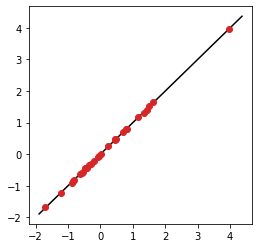

In [5]:
x_sample = numpy.mean(phi.sample(10000), axis=0)
pyplot.figure(figsize=(4,4))
pyplot.plot([1.1 * numpy.amin(x_sample), 1.1 * numpy.amax(x_sample)], [1.1 * numpy.amin(x_sample), 1.1 * numpy.amax(x_sample)] ,'k')
pyplot.plot(x_sample.flatten(), phi.integrate('x').flatten(), 'C3o')

$\int Ax + b du(x)$

In [6]:
k = 6
A_mat, a_vec = numpy.random.randn(k,D), numpy.random.randn(k)
x_sample = phi.sample(10000)
Ax_a_sample = numpy.mean(numpy.einsum('ab,cdb->cda', A_mat, x_sample) + a_vec, axis=0)
Ax_a_phi = phi.integrate('Ax_a', A_mat=A_mat, a_vec=a_vec)

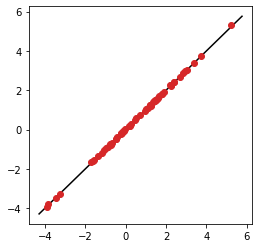

In [7]:
pyplot.figure(figsize=(4,4))
pyplot.plot([1.1 * numpy.amin(Ax_a_sample), 1.1 * numpy.amax(Ax_a_sample)], [1.1 * numpy.amin(Ax_a_sample), 1.1 * numpy.amax(Ax_a_sample)] ,'k')
pyplot.plot(Ax_a_sample.flatten(), Ax_a_phi.flatten(), 'C3o')

### Test for quadratic intergal

$\int xx^\top du(x)$

In [8]:
R, D, R1 = 20, 2, 1
rand_nums = numpy.random.randn(D,D)
Sigma_phi = numpy.dot(rand_nums, rand_nums.T) + D * numpy.eye(D)
Sigma_phi = numpy.tile(Sigma_phi, (R, 1, 1))
mu_phi = numpy.random.randn(R, D)
phi = densities.GaussianDensity(Sigma=Sigma_phi, mu=mu_phi)

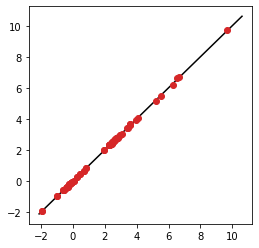

In [9]:
x_sample = phi.sample(10000)
x2_sample = numpy.mean(x_sample[:,:,None] * x_sample[:,:,:,None], axis=0)
phi_integral = phi.integrate('xx')
pyplot.figure(figsize=(4,4))
pyplot.plot([1.1 * numpy.amin(x2_sample), 1.1 * numpy.amax(x2_sample)], [1.1 * numpy.amin(x2_sample), 1.1 * numpy.amax(x2_sample)] ,'k')
pyplot.plot(x2_sample.flatten(), phi_integral.flatten(), 'C3o')

$\int (Ax+a)^\top (Bx+b) du(x)$

In [10]:
k = 6
A_mat, a_vec = numpy.random.randn(k,D), numpy.random.randn(k)
B_mat, b_vec = numpy.random.randn(k,D), numpy.random.randn(k)
x_sample = phi.sample(10000)
Ax_a_sample = numpy.einsum('ab,cdb->cda', A_mat, x_sample) + a_vec
Bx_b_sample = numpy.einsum('ab,cdb->cda', B_mat, x_sample) + b_vec
AB_sample = numpy.mean(numpy.einsum('abc,abc->ab', Ax_a_sample, Bx_b_sample), axis=0)
AB_phi = phi.integrate('Ax_aBx_b_inner', A_mat=A_mat, a_vec=a_vec, B_mat=B_mat, b_vec=b_vec)

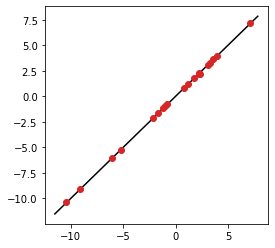

In [11]:
pyplot.figure(figsize=(4,4))
pyplot.plot([1.1 * numpy.amin(AB_sample), 1.1 * numpy.amax(AB_sample)], [1.1 * numpy.amin(AB_sample), 1.1 * numpy.amax(AB_sample)] ,'k')
pyplot.plot(AB_sample.flatten(), AB_phi.flatten(), 'C3o')

In [12]:
k, l = 6, 3
A_mat, a_vec = numpy.random.randn(k,D), numpy.random.randn(k)
B_mat, b_vec = numpy.random.randn(l,D), numpy.random.randn(l)
x_sample = phi.sample(10000)
Ax_a_sample = numpy.einsum('ab,cdb->cda', A_mat, x_sample) + a_vec
Bx_b_sample = numpy.einsum('ab,cdb->cda', B_mat, x_sample) + b_vec
AB_sample = numpy.mean(numpy.einsum('abc,abd->abcd', Ax_a_sample, Bx_b_sample), axis=0)
AB_phi = phi.integrate('Ax_aBx_b_outer', A_mat=A_mat, a_vec=a_vec, B_mat=B_mat, b_vec=b_vec)

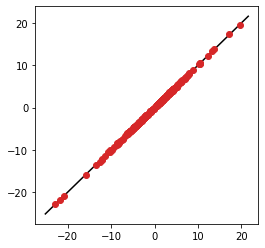

In [13]:
pyplot.figure(figsize=(4,4))
pyplot.plot([1.1 * numpy.amin(AB_sample), 1.1 * numpy.amax(AB_sample)], [1.1 * numpy.amin(AB_sample), 1.1 * numpy.amax(AB_sample)] ,'k')
pyplot.plot(AB_sample.flatten(), AB_phi.flatten(), 'C3o')

### Test for cubic intergal

$\int (Ax+a)(Bx+b)^\top(Cx+c) du(x)$

In [14]:
k, l = D, 3
A_mat, a_vec = numpy.random.randn(k,D), numpy.random.randn(k)
B_mat, b_vec = numpy.random.randn(l,D), numpy.random.randn(l)
C_mat, c_vec = numpy.random.randn(l,D), numpy.random.randn(l)
x_sample = phi.sample(10000)
Ax_a_sample = numpy.einsum('ab,cdb->cda', A_mat, x_sample) + a_vec
Bx_b_sample = numpy.einsum('ab,cdb->cda', B_mat, x_sample) + b_vec
Cx_c_sample = numpy.einsum('ab,cdb->cda', C_mat, x_sample) + c_vec
ABC_sample = numpy.mean(Ax_a_sample * numpy.einsum('abc,abc->ab', Bx_b_sample, Cx_c_sample)[:,:,None], axis=0)
ABC_phi = phi.integrate('Ax_aBx_bCx_c_inner', A_mat=A_mat, a_vec=a_vec, B_mat=B_mat, b_vec=b_vec, C_mat=C_mat, c_vec=c_vec)

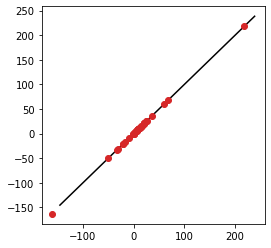

In [15]:
pyplot.figure(figsize=(4,4))
pyplot.plot([.9 * numpy.amin(ABC_sample), 1.1 * numpy.amax(ABC_sample)], [.9 * numpy.amin(ABC_sample), 1.1 * numpy.amax(ABC_sample)] ,'k')
pyplot.plot(ABC_sample.flatten(), ABC_phi.flatten(), 'C3o')

$\int (Ax+a)^\top(Bx+b)(Cx+c)^\top du(x)$

In [16]:
k, l = D, 3
A_mat, a_vec = numpy.random.randn(l,D), numpy.random.randn(l)
B_mat, b_vec = numpy.random.randn(l,D), numpy.random.randn(l)
C_mat, c_vec = numpy.random.randn(k,D), numpy.random.randn(k)
x_sample = phi.sample(10000)
Ax_a_sample = numpy.einsum('ab,cdb->cda', A_mat, x_sample) + a_vec
Bx_b_sample = numpy.einsum('ab,cdb->cda', B_mat, x_sample) + b_vec
Cx_c_sample = numpy.einsum('ab,cdb->cda', C_mat, x_sample) + c_vec
ABC_sample = numpy.mean(numpy.einsum('abc,abcd->abd', Ax_a_sample, numpy.einsum('abc,abd->abcd', Bx_b_sample, Cx_c_sample)), axis=0)
ABC_phi = phi.integrate('Ax_aBx_bCx_c_outer', A_mat=A_mat, a_vec=a_vec, B_mat=B_mat, b_vec=b_vec, C_mat=C_mat, c_vec=c_vec)

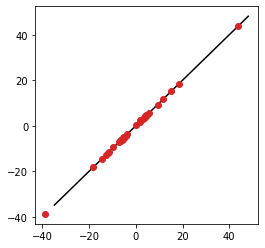

In [17]:
pyplot.figure(figsize=(4,4))
pyplot.plot([.9 * numpy.amin(ABC_sample), 1.1 * numpy.amax(ABC_sample)], [.9 * numpy.amin(ABC_sample), 1.1 * numpy.amax(ABC_sample)] ,'k')
pyplot.plot(ABC_sample.flatten(), ABC_phi.flatten(), 'C3o')

## Test quartic integrals

$\int (Ax+a)(Bx+b)^\top(Cx+c)(Dx+d)^\top du(x)$ 

In [18]:
m,l,k = 4,6,8
A_mat, a_vec = numpy.random.randn(m,D), numpy.random.rand(m)
B_mat, b_vec = numpy.random.randn(l,D), numpy.random.rand(l)
C_mat, c_vec = numpy.random.randn(l,D), numpy.random.rand(l)
D_mat, d_vec = numpy.random.randn(k,D), numpy.random.rand(k)

x_sample = phi.sample(10000)
Ax_a_sample = numpy.einsum('ab,cdb->cda', A_mat, x_sample) + a_vec
Bx_b_sample = numpy.einsum('ab,cdb->cda', B_mat, x_sample) + b_vec
Cx_c_sample = numpy.einsum('ab,cdb->cda', C_mat, x_sample) + c_vec
Dx_d_sample = numpy.einsum('ab,cdb->cda', D_mat, x_sample) + d_vec
AB_sample = numpy.einsum('abc,abd->abcd', Ax_a_sample, Bx_b_sample)
CD_sample = numpy.einsum('abc,abd->abcd', Cx_c_sample, Dx_d_sample)
ABCD_sample = numpy.mean(numpy.einsum('abcd,abde->abce', AB_sample, CD_sample), axis=0)
ABCD_phi = phi.integrate('Ax_aBx_bCx_cDx_d_outer', A_mat=A_mat, a_vec=a_vec, B_mat=B_mat, b_vec=b_vec, C_mat=C_mat, c_vec=c_vec, D_mat=D_mat, d_vec=d_vec)

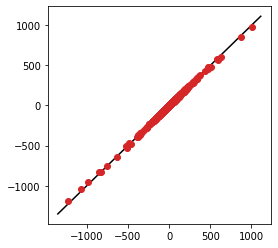

In [19]:
pyplot.figure(figsize=(4,4))
pyplot.plot([1.1 * numpy.amin(ABCD_sample), 1.1 * numpy.amax(ABCD_sample)], [1.1 * numpy.amin(ABCD_sample), 1.1 * numpy.amax(ABCD_sample)] ,'k')
pyplot.plot(ABCD_sample.flatten(), ABCD_phi.flatten(), 'C3o')

$\int (Ax+a)^\top(Bx+b)(Cx+c)^\top(Dx+d) du(x)$ 

In [20]:
m,l = 10,12
A_mat, a_vec = numpy.random.randn(m,D), numpy.random.rand(m)
B_mat, b_vec = numpy.random.randn(m,D), numpy.random.rand(m)
C_mat, c_vec = numpy.random.randn(l,D), numpy.random.rand(l)
D_mat, d_vec = numpy.random.randn(l,D), numpy.random.rand(l)

x_sample = phi.sample(10000)
Ax_a_sample = numpy.einsum('ab,cdb->cda', A_mat, x_sample) + a_vec
Bx_b_sample = numpy.einsum('ab,cdb->cda', B_mat, x_sample) + b_vec
Cx_c_sample = numpy.einsum('ab,cdb->cda', C_mat, x_sample) + c_vec
Dx_d_sample = numpy.einsum('ab,cdb->cda', D_mat, x_sample) + d_vec
AB_sample = numpy.einsum('abc,abc->ab', Ax_a_sample, Bx_b_sample)
CD_sample = numpy.einsum('abc,abc->ab', Cx_c_sample, Dx_d_sample)
ABCD_sample = numpy.mean(AB_sample * CD_sample, axis=0)
ABCD_phi = phi.integrate('Ax_aBx_bCx_cDx_d_inner', A_mat=A_mat, a_vec=a_vec, B_mat=B_mat, b_vec=b_vec, C_mat=C_mat, c_vec=c_vec, D_mat=D_mat, d_vec=d_vec)

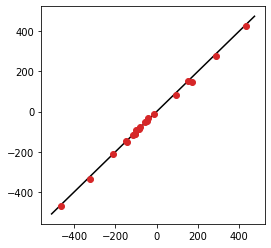

In [21]:
pyplot.figure(figsize=(4,4))
pyplot.plot([1.1 * numpy.amin(ABCD_sample), 1.1 * numpy.amax(ABCD_sample)], [1.1 * numpy.amin(ABCD_sample), 1.1 * numpy.amax(ABCD_sample)] ,'k')
pyplot.plot(ABCD_sample.flatten(), ABCD_phi.flatten(), 'C3o')

## Test 2 Dimensional

In [22]:
R, D, R1 = 1, 2, 1
rand_nums = numpy.random.randn(D,D)
Sigma_phi = 5. * numpy.ones((D,D))
Sigma_phi += 1e-1*numpy.eye(D)

Sigma_phi = numpy.tile(Sigma_phi, (R, 1, 1))
mu_phi = numpy.zeros((R, D))
mu_phi[0,0] = 2 
phi = densities.GaussianDensity(Sigma=Sigma_phi, mu=mu_phi)
x_samples = phi.sample(100000)
numpy_samples = numpy.random.multivariate_normal(mu_phi[0], Sigma_phi[0], 100000)

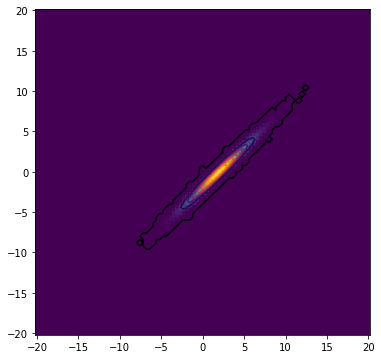

In [23]:
pyplot.figure(figsize=(6,6))
xrange = numpy.linspace(-20,20,100)
xmesh, ymesh = numpy.meshgrid(xrange, xrange)
x_grid = numpy.vstack([xmesh.flatten(), ymesh.flatten()])
density = phi.evaluate(x_grid.T)[0].reshape((100,100))
hist, xedges, yedges =  numpy.histogram2d(x_samples[:,0,1], x_samples[:,0,0], range=[[-20,20], [-20,20]], bins=100)
numpy_hist, xedges, yedges =  numpy.histogram2d(numpy_samples[:,1], numpy_samples[:,0], range=[[-20,20], [-20,20]], bins=100)
ax1 = pyplot.subplot(111)
pyplot.pcolor(xrange, xrange, density, shading='auto')
#pyplot.pcolor(xedges[:-1], yedges[:-1], numpy_hist, shading='auto')
pyplot.contour(xedges[:-1], yedges[:-1], hist, cmap='inferno')
pyplot.show()

## Test adding Terms and then integrating

In [24]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot
import numpy
from scipy.linalg import solve_triangular
import sys
sys.path.append('../src/')
import factors
import densities
import measures

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
R, D = 100, 2
rand_nums = numpy.random.randn(D,D)
Sigma_phi = numpy.dot(rand_nums, rand_nums.T) + D * numpy.eye(D)
#Sigma_phi = 10 * numpy.eye(D)
#Sigma_phi = 5. * numpy.ones((D,D))
#Sigma_phi += 1e-1*numpy.eye(D)
Sigma_phi = numpy.tile(Sigma_phi, (R, 1, 1))
mu_phi = numpy.random.randn(R, D)

$\int \beta d \phi(x)$

In [26]:
phi = densities.GaussianDensity(Sigma=Sigma_phi, mu=mu_phi)
R2 = 2
ln_beta = numpy.random.randn(R2)
#u = phi.multiply_constant_term(ln_beta)
factor = factors.ConstantFactor(ln_beta, D)
u = phi.multiply(factor, False)
numpy.allclose(u.integral(), numpy.exp(numpy.tile(ln_beta[None], (R, 1)).reshape(R * R2)))

True

$\ln \int \beta \exp(\nu^\top x) d \phi(x)$

In [27]:
from scipy.special import logsumexp
num_samples = 100000
phi = densities.GaussianDensity(Sigma=Sigma_phi, mu=mu_phi)
R2 = 3
ln_beta = numpy.random.randn(R2)
nu = numpy.dot(numpy.random.randn(R2, D), phi.Lambda[0])
factor = factors.LinearFactor(nu, ln_beta)
u = phi.multiply(factor, False)
x_sample = phi.sample(num_samples)
xnu_sample = numpy.einsum('abc,dc->abd', x_sample, nu) 
log_integral = xnu_sample + ln_beta[None,None]
sampled_integral = logsumexp(log_integral, axis=0).reshape((R * R2)) - numpy.log(num_samples)
phi_term = u.log_integral()

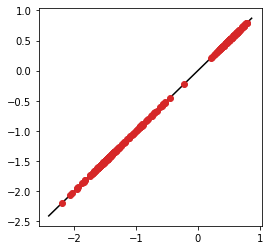

In [28]:
pyplot.figure(figsize=(4,4))
pyplot.plot([1.1 * numpy.amin(sampled_integral), 1.1 * numpy.amax(sampled_integral)], [1.1 * numpy.amin(sampled_integral), 1.1 * numpy.amax(sampled_integral)] ,'k')
pyplot.plot(sampled_integral.flatten(), phi_term.flatten(), 'C3o')

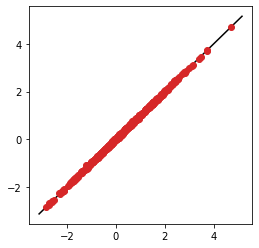

In [29]:
u_density = u.get_density()
x_sample = u_density.sample(10000)
pyplot.figure(figsize=(4,4))
pyplot.plot([1.1 * numpy.amin(u_density.mu), 1.1 * numpy.amax(u_density.mu)], [1.1 * numpy.amin(u_density.mu), 1.1 * numpy.amax(u_density.mu)] ,'k')
pyplot.plot(numpy.mean(x_sample, axis=0).flatten(), u_density.mu.flatten(), 'C3o')

$\int \beta \exp(- \frac{1}{2}x^\top\Lambda x + \nu^\top x) d \phi(x)$

In [30]:
R, D = 100, 2
rand_nums = numpy.random.randn(D,D)
Sigma_phi = numpy.dot(rand_nums, rand_nums.T) + D * numpy.eye(D)
#Sigma_phi = numpy.eye(D)
Sigma_phi = numpy.tile(Sigma_phi, (R, 1, 1))
mu_phi = numpy.random.randn(R, D)
phi = densities.GaussianDensity(Sigma=Sigma_phi, mu=mu_phi)
R2 = 1
ln_beta = numpy.random.randn(R2)
nu = numpy.dot(numpy.random.randn(R2, D), phi.Lambda[0])
Lambda = numpy.dot(rand_nums, rand_nums.T) + D * numpy.eye(D)
Lambda = numpy.tile(Lambda, (R2, 1, 1))
factor = factors.ConjugateFactor(Lambda, nu, ln_beta)
u = phi.multiply(factor, False)
x_sample = phi.sample(10000)
xLambdax_sample = numpy.einsum('abcd,abd->abc', numpy.einsum('abc,dce->abde', x_sample, Lambda), x_sample)
xnu_sample = numpy.einsum('abc,dc->abd', x_sample, nu) 
integral = numpy.exp(-.5 * xLambdax_sample + xnu_sample + ln_beta[None,:,None])
#integral = numpy.exp(-.5 * xLambdax_sample + xnu_sample)
sampled_integral = numpy.mean(integral, axis=0).reshape((R * R2))
phi_term = u.integrate()

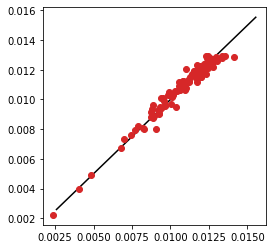

In [31]:
pyplot.figure(figsize=(4,4))
pyplot.plot([1.1 * numpy.amin(sampled_integral), 1.1 * numpy.amax(sampled_integral)], [1.1 * numpy.amin(sampled_integral), 1.1 * numpy.amax(sampled_integral)] ,'k')
pyplot.plot(sampled_integral.flatten(), phi_term.flatten(), 'C3o')

$\int (Ax+a)(Bx+b)^\top(Cx+c)(Dx+d)^\top \beta \exp(- \frac{1}{2}x^\top\Lambda x + \nu^\top x) d \phi(x)$

In [32]:
m,l,k = 4,6,8
A_mat, a_vec = numpy.random.randn(m,D), numpy.random.rand(m)
B_mat, b_vec = numpy.random.randn(l,D), numpy.random.rand(l)
C_mat, c_vec = numpy.random.randn(l,D), numpy.random.rand(l)
D_mat, d_vec = numpy.random.randn(k,D), numpy.random.rand(k)

Ax_a_sample = numpy.einsum('ab,cdb->cda', A_mat, x_sample) + a_vec
Bx_b_sample = numpy.einsum('ab,cdb->cda', B_mat, x_sample) + b_vec
Cx_c_sample = numpy.einsum('ab,cdb->cda', C_mat, x_sample) + c_vec
Dx_d_sample = numpy.einsum('ab,cdb->cda', D_mat, x_sample) + d_vec
AB_sample = numpy.einsum('abc,abd->abcd', Ax_a_sample, Bx_b_sample)
CD_sample = numpy.einsum('abc,abd->abcd', Cx_c_sample, Dx_d_sample)
ABCD_sample = numpy.mean(numpy.einsum('abcd,abde->abce', AB_sample, CD_sample)[:,:,None] * integral[:,:,:,None,None], axis=0).reshape((R*R2,m,k))
ABCD_phi = u.integrate('Ax_aBx_bCx_cDx_d_outer', A_mat=A_mat, a_vec=a_vec, B_mat=B_mat, b_vec=b_vec, C_mat=C_mat, c_vec=c_vec, D_mat=D_mat, d_vec=d_vec)

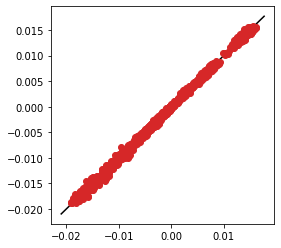

In [33]:
pyplot.figure(figsize=(4,4))
pyplot.plot([1.1 * numpy.amin(ABCD_sample), 1.1 * numpy.amax(ABCD_sample)], [1.1 * numpy.amin(ABCD_sample), 1.1 * numpy.amax(ABCD_sample)] ,'k')
pyplot.plot(ABCD_sample.flatten(), ABCD_phi.flatten(), 'C3o')

$\int (Ax+a)^\top(Bx+b)(Cx+c)^\top(Dx+d) \beta \exp(- \frac{1}{2}x^\top\Lambda x + \nu^\top x) d \phi(x)$ 

In [34]:
#u = phi.multiply_squared_exponential_term(Lambda, nu, ln_beta)

m,l = 10,12
A_mat, a_vec = numpy.random.randn(m,D), numpy.random.rand(m)
B_mat, b_vec = numpy.random.randn(m,D), numpy.random.rand(m)
C_mat, c_vec = numpy.random.randn(l,D), numpy.random.rand(l)
D_mat, d_vec = numpy.random.randn(l,D), numpy.random.rand(l)

Ax_a_sample = numpy.einsum('ab,cdb->cda', A_mat, x_sample) + a_vec
Bx_b_sample = numpy.einsum('ab,cdb->cda', B_mat, x_sample) + b_vec
Cx_c_sample = numpy.einsum('ab,cdb->cda', C_mat, x_sample) + c_vec
Dx_d_sample = numpy.einsum('ab,cdb->cda', D_mat, x_sample) + d_vec
AB_sample = numpy.einsum('abc,abc->ab', Ax_a_sample, Bx_b_sample)
CD_sample = numpy.einsum('abc,abc->ab', Cx_c_sample, Dx_d_sample)
ABCD_sample = numpy.mean((AB_sample * CD_sample)[:,:,None] * integral, axis=0).reshape((R * R2))
ABCD_phi = u.integrate('Ax_aBx_bCx_cDx_d_inner', A_mat=A_mat, a_vec=a_vec, B_mat=B_mat, b_vec=b_vec, C_mat=C_mat, c_vec=c_vec, D_mat=D_mat, d_vec=d_vec)

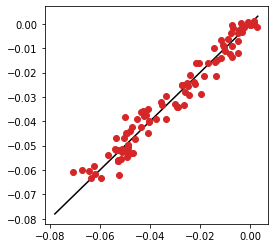

In [35]:
pyplot.figure(figsize=(4,4))
pyplot.plot([1.1 * numpy.amin(ABCD_sample), 1.1 * numpy.amax(ABCD_sample)], [1.1 * numpy.amin(ABCD_sample), 1.1 * numpy.amax(ABCD_sample)] ,'k')
pyplot.plot(ABCD_sample.flatten(), ABCD_phi.flatten(), 'C3o')

### Test for rank 1 update

$\int \exp(-\frac{1}{2}x^\top UGU^\top x) d \phi(x)$

In [36]:
R, D = 100, 2
rand_nums = numpy.random.randn(D,D)
Sigma_phi = numpy.dot(rand_nums, rand_nums.T) + D * numpy.eye(D)
Sigma_phi = numpy.tile(Sigma_phi, (R, 1, 1))
mu_phi = numpy.random.randn(R, D)
phi = densities.GaussianDensity(Sigma=Sigma_phi, mu=mu_phi)

In [37]:
R2 = 4
v = numpy.random.randn(R2, D)
v /= numpy.sum(v, axis=1)[:,None]
g = 20 * numpy.random.rand(R2)
Lambda = numpy.einsum('ab,ac->abc', v, g[:,None] * v)
#u = phi.multiply_rank_one(U, G)
#ln_beta = numpy.random.randn(R2)
#nu = numpy.random.randn(R2, D)
ln_beta = numpy.zeros(R2)
nu = numpy.zeros((R2, D))
factor = factors.OneRankFactor(v,g,nu,ln_beta)
u = phi.multiply(factor)
phi_term = u.integral()
x_sample = phi.sample(10000)
xLambdax_sample = numpy.einsum('abcd,abd->abc', numpy.einsum('abc,dce->abde', x_sample, Lambda), x_sample)
integral = numpy.exp(-.5 * xLambdax_sample)
sampled_integral = numpy.mean(integral, axis=0).reshape((R * R2))

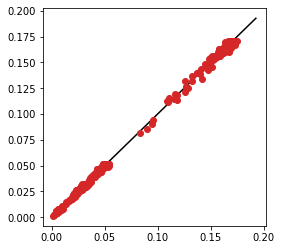

In [38]:
pyplot.figure(figsize=(4,4))
pyplot.plot([1.1 * numpy.amin(sampled_integral), 1.1 * numpy.amax(sampled_integral)], [1.1 * numpy.amin(sampled_integral), 1.1 * numpy.amax(sampled_integral)] ,'k')
pyplot.plot(sampled_integral.flatten(), phi_term.flatten(), 'C3o')

In [39]:
m,l,k = 5,6,8
A_mat, a_vec = numpy.random.randn(m,D), numpy.random.rand(m)
B_mat, b_vec = numpy.random.randn(l,D), numpy.random.rand(l)
C_mat, c_vec = numpy.random.randn(l,D), numpy.random.rand(l)
D_mat, d_vec = numpy.random.randn(k,D), numpy.random.rand(k)

Ax_a_sample = numpy.einsum('ab,cdb->cda', A_mat, x_sample) + a_vec
Bx_b_sample = numpy.einsum('ab,cdb->cda', B_mat, x_sample) + b_vec
Cx_c_sample = numpy.einsum('ab,cdb->cda', C_mat, x_sample) + c_vec
Dx_d_sample = numpy.einsum('ab,cdb->cda', D_mat, x_sample) + d_vec
AB_sample = numpy.einsum('abc,abd->abcd', Ax_a_sample, Bx_b_sample)
CD_sample = numpy.einsum('abc,abd->abcd', Cx_c_sample, Dx_d_sample)
ABCD_sample = numpy.mean(numpy.einsum('abcd,abde->abce', AB_sample, CD_sample)[:,:,None] * integral[:,:,:,None,None], axis=0).reshape((R*R2,m,k))
#ABCD_sample = numpy.mean(numpy.einsum('abcd,abde->abce', AB_sample, CD_sample)[:,:,None], axis=0).reshape((R,m,k))
ABCD_phi = u.integrate_general_quartic_outer(A_mat, a_vec, B_mat, b_vec, C_mat, c_vec, D_mat, d_vec)

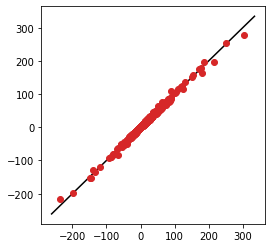

In [40]:
pyplot.figure(figsize=(4,4))
pyplot.plot([1.1 * numpy.amin(ABCD_sample), 1.1 * numpy.amax(ABCD_sample)], [1.1 * numpy.amin(ABCD_sample), 1.1 * numpy.amax(ABCD_sample)] ,'k')
pyplot.plot(ABCD_sample.flatten(), ABCD_phi.flatten(), 'C3o')

## Real test: Integrating kernels with respect to a Gaussian density

In [41]:
R, D = 1, 2
Sigma_phi = numpy.eye(D)
Sigma_phi = numpy.tile(Sigma_phi, (R, 1, 1))
mu_phi = numpy.zeros((R, D))
num_kernels = 100
center_range = numpy.linspace(-2,2,int(numpy.sqrt(num_kernels)))
center_mesh = numpy.meshgrid(center_range, center_range)
centers_kernel = numpy.vstack([center_mesh[0].flatten(), center_mesh[1].flatten()]).T
kernel_width = 1.
Lambda_kernel = 1. / kernel_width * numpy.eye(D)
Lambda_kernel = numpy.tile(Lambda_kernel, (num_kernels, 1, 1))
nu_kernel = centers_kernel / kernel_width
ln_beta_kernel = -numpy.sum(kernel_width * nu_kernel ** 2, axis=1)


In [42]:
phi = densities.GaussianDensity(Sigma_phi, mu_phi)
kernel = factors.ConjugateFactor(Lambda=Lambda_kernel, nu=nu_kernel, ln_beta=ln_beta_kernel)

In [43]:
kk_phi = phi.multiply(kernel).multiply(kernel)
integral = kk_phi.integrate()

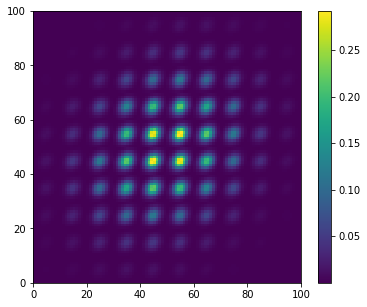

In [44]:
pyplot.figure(figsize=(6,5))
pyplot.pcolor(integral.reshape((num_kernels, num_kernels)))
pyplot.colorbar()

In [45]:
k_phi = phi.multiply(kernel)
integral = k_phi.integrate()

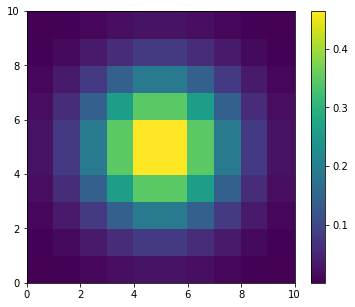

In [46]:
pyplot.figure(figsize=(6,5))
pyplot.pcolor(integral.reshape((10, 10)))
pyplot.colorbar()

## Gaussian mixture

In [91]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot
import numpy
from scipy.linalg import solve_triangular
import sys
sys.path.append('../src/')
import factors
import densities
import measures

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
R, D = 10, 2
num_components = 10
components = []
weights = numpy.random.rand(num_components)

for icomp in range(num_components):
    rand_nums = numpy.random.randn(D,D)
    Sigma_phi = .1 * (numpy.dot(rand_nums, rand_nums.T) + D * numpy.eye(D))
    Sigma_phi = numpy.tile(Sigma_phi, (R, 1, 1))
    mu_phi = 3 * numpy.random.randn(R, D)
    components.append(densities.GaussianDensity(Sigma=Sigma_phi, mu=mu_phi))
phi = densities.GaussianMixtureDensity(components, weights)
x_samples = phi.sample(100000)

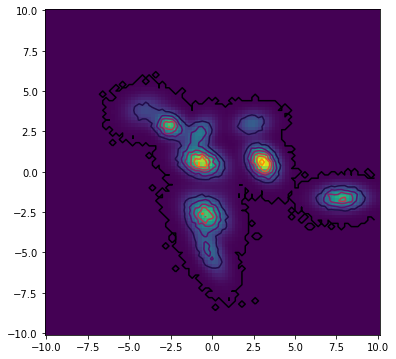

In [104]:
pyplot.figure(figsize=(6,6))
xrange = numpy.linspace(-10,10,100)
xmesh, ymesh = numpy.meshgrid(xrange, xrange)
x_grid = numpy.vstack([xmesh.flatten(), ymesh.flatten()])
density = phi.evaluate(x_grid.T)[0].reshape((100,100))
hist, xedges, yedges =  numpy.histogram2d(x_samples[:,0,1], x_samples[:,0,0], range=[[-10,10], [-10,10]], bins=100)
numpy_hist, xedges, yedges =  numpy.histogram2d(numpy_samples[:,1], numpy_samples[:,0], range=[[-10,10], [-10,10]], bins=100)
ax1 = pyplot.subplot(111)
pyplot.pcolor(xrange, xrange, density, shading='auto')
#pyplot.pcolor(xedges[:-1], yedges[:-1], numpy_hist, shading='auto')
pyplot.contour(xedges[:-1], yedges[:-1], hist, cmap='inferno')
pyplot.show()

$\int (Ax+a)(Bx+b)^\top(Cx+c)(Dx+d)^\top du(x)$ 

In [105]:
m,l,k = 4,6,8
A_mat, a_vec = numpy.random.randn(m,D), numpy.random.rand(m)
B_mat, b_vec = numpy.random.randn(l,D), numpy.random.rand(l)
C_mat, c_vec = numpy.random.randn(l,D), numpy.random.rand(l)
D_mat, d_vec = numpy.random.randn(k,D), numpy.random.rand(k)

x_sample = phi.sample(10000)
Ax_a_sample = numpy.einsum('ab,cdb->cda', A_mat, x_sample) + a_vec
Bx_b_sample = numpy.einsum('ab,cdb->cda', B_mat, x_sample) + b_vec
Cx_c_sample = numpy.einsum('ab,cdb->cda', C_mat, x_sample) + c_vec
Dx_d_sample = numpy.einsum('ab,cdb->cda', D_mat, x_sample) + d_vec
AB_sample = numpy.einsum('abc,abd->abcd', Ax_a_sample, Bx_b_sample)
CD_sample = numpy.einsum('abc,abd->abcd', Cx_c_sample, Dx_d_sample)
ABCD_sample = numpy.mean(numpy.einsum('abcd,abde->abce', AB_sample, CD_sample), axis=0)
ABCD_phi = phi.integrate('Ax_aBx_bCx_cDx_d_outer', A_mat=A_mat, a_vec=a_vec, B_mat=B_mat, b_vec=b_vec, C_mat=C_mat, c_vec=c_vec, D_mat=D_mat, d_vec=d_vec)

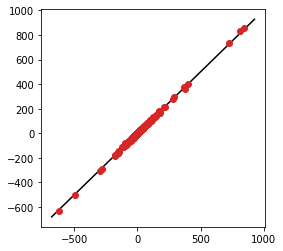

In [106]:
pyplot.figure(figsize=(4,4))
pyplot.plot([1.1 * numpy.amin(ABCD_sample), 1.1 * numpy.amax(ABCD_sample)], [1.1 * numpy.amin(ABCD_sample), 1.1 * numpy.amax(ABCD_sample)] ,'k')
pyplot.plot(ABCD_sample.flatten(), ABCD_phi.flatten(), 'C3o')

$\int (Ax+a)^\top(Bx+b)(Cx+c)^\top(Dx+d) du(x)$ 

In [107]:
m,l = 10,12
A_mat, a_vec = numpy.random.randn(m,D), numpy.random.rand(m)
B_mat, b_vec = numpy.random.randn(m,D), numpy.random.rand(m)
C_mat, c_vec = numpy.random.randn(l,D), numpy.random.rand(l)
D_mat, d_vec = numpy.random.randn(l,D), numpy.random.rand(l)

x_sample = phi.sample(10000)
Ax_a_sample = numpy.einsum('ab,cdb->cda', A_mat, x_sample) + a_vec
Bx_b_sample = numpy.einsum('ab,cdb->cda', B_mat, x_sample) + b_vec
Cx_c_sample = numpy.einsum('ab,cdb->cda', C_mat, x_sample) + c_vec
Dx_d_sample = numpy.einsum('ab,cdb->cda', D_mat, x_sample) + d_vec
AB_sample = numpy.einsum('abc,abc->ab', Ax_a_sample, Bx_b_sample)
CD_sample = numpy.einsum('abc,abc->ab', Cx_c_sample, Dx_d_sample)
ABCD_sample = numpy.mean(AB_sample * CD_sample, axis=0)
ABCD_phi = phi.integrate('Ax_aBx_bCx_cDx_d_inner', A_mat=A_mat, a_vec=a_vec, B_mat=B_mat, b_vec=b_vec, C_mat=C_mat, c_vec=c_vec, D_mat=D_mat, d_vec=d_vec)

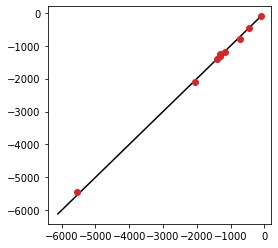

In [108]:
pyplot.figure(figsize=(4,4))
pyplot.plot([1.1 * numpy.amin(ABCD_sample), 1.1 * numpy.amax(ABCD_sample)], [1.1 * numpy.amin(ABCD_sample), 1.1 * numpy.amax(ABCD_sample)] ,'k')
pyplot.plot(ABCD_sample.flatten(), ABCD_phi.flatten(), 'C3o')

$\int \beta \exp(- \frac{1}{2}x^\top\Lambda x + \nu^\top x) d \phi(x)$

In [118]:
R, D = 10, 2
num_components = 10
components = []
weights = numpy.random.rand(num_components)

for icomp in range(num_components):
    rand_nums = numpy.random.randn(D,D)
    Sigma_phi = .1 * (numpy.dot(rand_nums, rand_nums.T) + D * numpy.eye(D))
    Sigma_phi = numpy.tile(Sigma_phi, (R, 1, 1))
    mu_phi = 3 * numpy.random.randn(R, D)
    components.append(densities.GaussianDensity(Sigma=Sigma_phi, mu=mu_phi))
phi = densities.GaussianMixtureDensity(components, weights)

x_samples = phi.sample(100000)
R2 = 1
ln_beta = numpy.random.randn(R2)
nu = numpy.dot(numpy.random.randn(R2, D), phi.components[numpy.argmax(phi.weights)].Lambda[0])
Lambda = numpy.dot(rand_nums, rand_nums.T) + D * numpy.eye(D)
Lambda = numpy.tile(Lambda, (R2, 1, 1))
factor = factors.ConjugateFactor(Lambda, nu, ln_beta)
u = phi.multiply(factor, False)
x_sample = phi.sample(10000)
xLambdax_sample = numpy.einsum('abcd,abd->abc', numpy.einsum('abc,dce->abde', x_sample, Lambda), x_sample)
xnu_sample = numpy.einsum('abc,dc->abd', x_sample, nu) 
integral = numpy.exp(-.5 * xLambdax_sample + xnu_sample + ln_beta[None,:,None])
#integral = numpy.exp(-.5 * xLambdax_sample + xnu_sample)
sampled_integral = numpy.mean(integral, axis=0).reshape((R * R2))
phi_term = u.integrate()

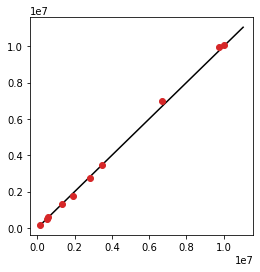

In [119]:
pyplot.figure(figsize=(4,4))
pyplot.plot([1.1 * numpy.amin(sampled_integral), 1.1 * numpy.amax(sampled_integral)], [1.1 * numpy.amin(sampled_integral), 1.1 * numpy.amax(sampled_integral)] ,'k')
pyplot.plot(sampled_integral.flatten(), phi_term.flatten(), 'C3o')